In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyStochastic = MdpKernel()
mdpPolicyStochastic.load_policy(mdpKernelParams, policyMode="deterministic", randomR=True)
mdpPolicyDeterministic = MdpKernel()
mdpPolicyDeterministic.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)

# ==== Prepare Simulator====
num_windows = 2000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyDeterministic, env)
simResultDeterministic = policySimulator.runSimulation(mdpPolicyDeterministic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
'''
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultDeterministic['uRecord'], 
    simResultDeterministic['actionsRecord'], 
    simResultDeterministic['rewardRecord'], 
    simResultDeterministic['uNextRecord']
)
'''
num_windows = 200
policySimulator = PolicySimulator(mdpPolicyStochastic, env)
simResultStochastic = policySimulator.runSimulation(mdpPolicyStochastic, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
uRecord = np.concatenate((simResultStochastic['uRecord'], simResultDeterministic['uRecord']))
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultStochastic['uRecord'] + simResultDeterministic['uRecord'], 
    simResultStochastic['actionsRecord'] + simResultDeterministic['actionsRecord'], 
    simResultStochastic['rewardRecord'] + simResultDeterministic['rewardRecord'], 
    simResultStochastic['uNextRecord'] + simResultDeterministic['uNextRecord']
)

Simulation Progress: 100%|██████████| 200/200 [00:00<00:00, 600.19it/s, avg reward=0.004460]


In [4]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 1e-2,
    'eta': 0.1,
    'N_action_candidates': 50
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env, epochs=500,batch_size=512)

torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')

Evaluation windows: 100%|██████████| 500/500 [00:06<00:00, 75.47it/s]                                     


Epoch   50/ 500  Avg Ld=0.254532  Avg Lq=-0.745496  Avg loss_critic=0.040170  Test packet loss=0.0052


KeyboardInterrupt: 

In [18]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl


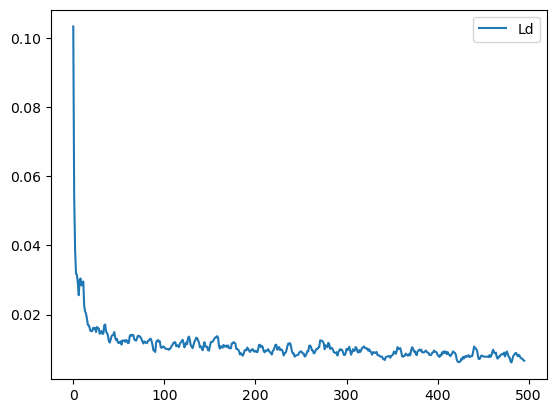

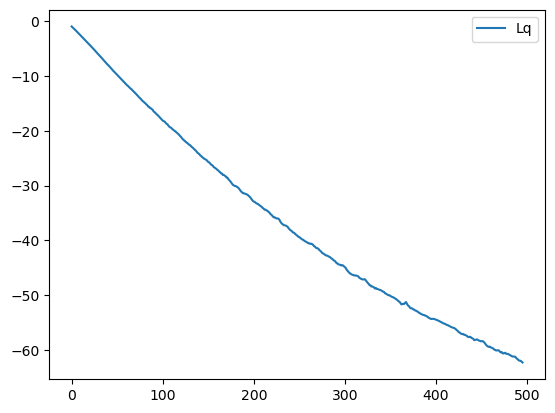

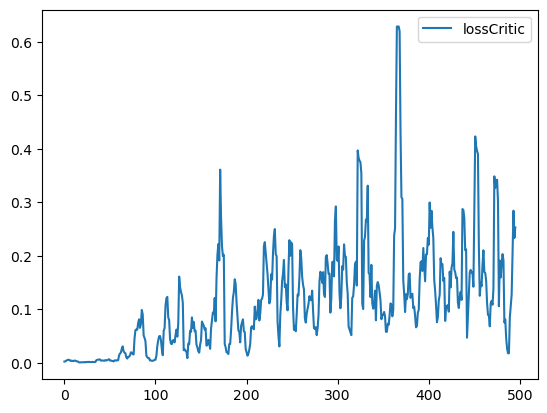

In [20]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 5
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()